In [177]:
## Standard libraries
import time
import json
import math
import numpy as np
import scipy
from scipy.linalg import fractional_matrix_power as frac_mat_pow

## Imports for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

def setup_gpu(seed=42):
    # Function for setting the seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Additionally, some operations on a GPU are implemented stochastic for efficiency
    # We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Fetching the device that will be used throughout this notebook
    device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
    print("Using device -> ", device)



In [186]:
N = 1000
T = 100
d = 1
Sigma = torch.eye(d)
Lambda = 0
memory = 0
X = [] 
Drift = []
Diffusion = []
input_output_pairs = []

In [187]:
long_term_mean = 0.01
mean_reversion = 0.5
volitality = 0.001

def mu(X):
    return (long_term_mean - X) * mean_reversion

def varsigma(X):
    return torch.ones(X.shape) * volitality

In [188]:
for t in range(T+1):
    if t == 0:
        X.append(torch.zeros(N, d)) # X[-1]
        Drift.append(torch.zeros(N, d))
        Diffusion.append(torch.zeros(N, d))
        X.append(torch.zeros(N, d)) # X[0]
        Drift.append(torch.zeros(N, d)) 
        Diffusion.append(torch.zeros(N, d))
    else:
        Z = torch.randn(N, d) # N x d 
        B = torch.bernoulli(torch.tensor([0.5]*N)) # N 
        drift_t = memory * mu(X[t-2]) + (1-memory) * mu(X[t-1]) # N x d 
        S = torch.einsum("n,dk->nk", (B * Lambda), torch.eye(d)) # N x d x d
        diffusion_t = S + torch.einsum("nd,dk->nk", varsigma(X[t-1]), Sigma) # N x d x d
        x_t = X[t-1] + drift_t + (diffusion_t * Z)
        X.append(x_t)
        Drift.append(drift_t)
        Diffusion.append(diffusion_t)
        

In [189]:
X_NTd = torch.stack(X, dim=1)
Drift_NTd = torch.stack(Drift, dim=1)
Diffusion_NTd = torch.stack(Diffusion, dim=1)

In [190]:
X = X_NTd[:, 0:, :]
Drift = Drift_NTd[:, 0:, :]
Diffusion = Diffusion_NTd[:, 0:, :]

In [173]:
sigma_2 = torch.matrix_power(Sigma,2)
sigma_neg_2 = torch.matrix_power(torch.linalg.pinv(Sigma), 2)

for t in range(1, T+2):
    x_t_1 = X[:, t-1, :]
    x_t = X[:, t, :]
    drift_t = Drift[:, t, :]

    mu_x_t =  x_t_1 + drift_t # N x d
    
    inner_power_arg = Lambda * torch.ones(N,d) +  torch.einsum("nd,dk->nk", varsigma(x_t_1), Sigma)
    inner_power = inner_power_arg**2

    outer_power_arg = torch.einsum("nd,dk->nk", inner_power, sigma_neg_2)
    outer_power = outer_power_arg**(1/2)

    sigma_x_t = torch.einsum("nd,dk->nk",outer_power, sigma_2) * varsigma(x_t_1)
    

In [176]:
t = 7
Lambda = 1
x_t_1 = X[:, t-1, :]
x_t = X[:, t, :]
drift_t = Drift[:, t, :]

mu_x_t =  x_t_1 + drift_t # N x d

inner_power_arg = (2 * torch.ones(N,d)) + torch.einsum("nd,dk->nk", varsigma(x_t_1), Sigma)
inner_power = inner_power_arg**2

sigma_neg_2 = torch.tensor([[1. ,0.], [0., 2.]])
outer_power_arg = torch.einsum("nd,dk->nd", inner_power, sigma_neg_2)
outer_power = outer_power_arg**(1/2)

sigma_x_t = torch.einsum("nd,dk->nk",outer_power, sigma_2) * varsigma(x_t_1) # N x d

Y = torch.cat((mu_x_t, sigma_x_t), dim = -1)
print(mu_x_t)
print(sigma_x_t)
print(Y)


tensor([[0.0215, 0.0101],
        [0.0010, 0.0071],
        [0.0337, 0.0057],
        [0.0277, 0.0033],
        [0.0108, 0.0078]])
tensor([[0.0327, 0.0298],
        [0.0039, 0.0105],
        [0.0670, 0.0142],
        [0.0435, 0.0148],
        [0.0219, 0.0216]])
tensor([[0.0215, 0.0101, 0.0327, 0.0298],
        [0.0010, 0.0071, 0.0039, 0.0105],
        [0.0337, 0.0057, 0.0670, 0.0142],
        [0.0277, 0.0033, 0.0435, 0.0148],
        [0.0108, 0.0078, 0.0219, 0.0216]])


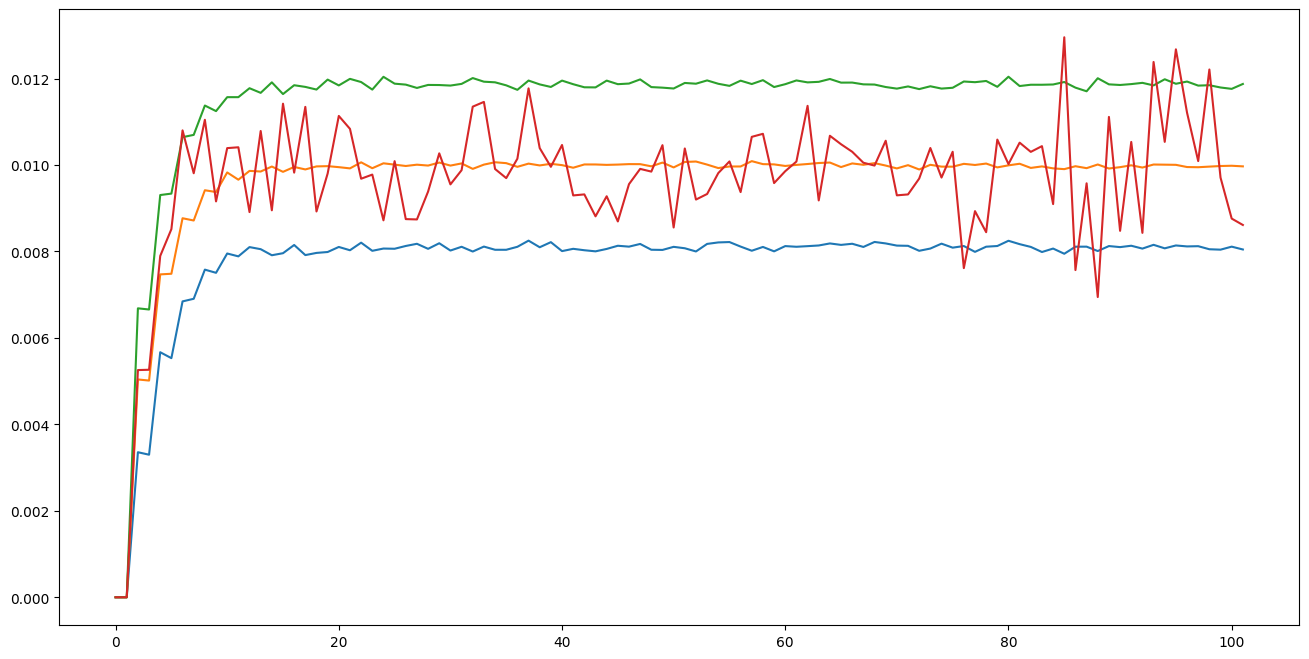

In [191]:
quantiles = torch.quantile(X, torch.tensor([0.05, 0.5, 0.95]), dim=0)
fig = plt.figure(figsize=(16,8))
plt.plot(quantiles[0])
plt.plot(quantiles[1])
plt.plot(quantiles[2])
plt.plot(X[0])